In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, '../python')
from fileOp import txt_load

# import modules
import numpy
import os
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
from skimage.color.colorlabel import label2rgb
from skimage.draw import line as skimage_line
import pickle

In [4]:
# Define GLOBAL variable
# define cases and colors for bounding box match
COLOR = ['r', 'y', 'y', 'b', 'g']
COLOR_FLOAT_MAT = [(1, 1, 1), (1, 1, 0), (1, 0, 1), (0, 0, 1), (0, 1, 0)]
COLOR_FLOAT_BB = [(1, 0, 0), (1, 1, 0), (1, 0, 1), (0, 0, 1), (0, 1, 0)]
MYCMAP = ListedColormap(COLOR)
DETLIST = ['no match', 'too large', 'too small', 'multiple match', 'hit']

In [5]:
def parse_xml(imdir, bbdir):
    ''' parse_xml(self, imdir, bbdir)

    load image and boundingbox files 
    imdir: _string_ contains directory for images
    bbdir: _string_ contains directory for boundingbox files '''

    root = []
    dirlist = os.listdir(imdir)
    for filename in dirlist:
        img_struct = dict()
        img_struct['filename'] = filename
        img_struct['bbstruct'] = get_bbstruct(bbdir, filename)
        root.append(img_struct)
    return root
        
def get_bbstruct(bbdir, filename):
    ''' _get_bbstruct(self, filename)

    get corresponding bb file for image
    filename: _string_ 
    Return _list_ contains file content '''

    bbname = os.path.join(bbdir, ('gt_'+filename.split('.')[0] + '.txt'))
    return open(bbname, 'r').readlines()

def _get_boundingbox(bb):
    '''_get_boundingbox(bb)
              
    read bounding box information from file
    bb: nods in xml file
    Return: _tuple_ contains bounding box (x, y, w, h)'''
    attrib = bb.strip().split(',')
    x = int(float(attrib[0]))
    y = int(float(attrib[1]))
    w = int(float(attrib[2]))
    h = int(float(attrib[3]))
    w = w - x
    h = h - y
    return (x, y, w, h)

def bbstruct2coor(bbstruct):
    ''' correct bounding box format for ground truth files '''
    Coor = []
    for bb in bbstruct:
        coor = _get_boundingbox(bb)
        c = list(coor)
        c[2] = coor[0] + coor[2]
        c[3] = coor[1] + coor[3]
        Coor.append(c)
    return Coor

def res2coor(filename, bbtxtdir):
    ''' correct bounding box format for predition result files '''
    bbname = os.path.join(bbtxtdir, ('res_'+ entry['filename'].split('.')[0] + '.txt'))
    pre = open(bbname, 'r').readlines()
    pre = bbstruct2coor(pre)
    return pre
    #pre1 = []
    #for p in pre:
    #    p1 = [p[1], p[0], p[3], p[2]]
    #    pre1.append(p1)
    #return pre1
    

def getEval(gt, pre):
    '''  getEval(gt, pre)
    
    evaluate precision and recall values between ground truth and predictions 
    gt: list of list containing ground truth information
    pre: list of list containing prediction information
    Return: premat, 2D numpy array containing precision between bounding boxes
            recmat, 2D numpy array containing recall between bounding boxes'''
    if not gt:
        #print 'empty gt'
        return numpy.zeros((1, len(pre))), numpy.zeros((1, len(pre)))
    elif not pre:
        #print 'empty pred'
        return numpy.zeros((len(gt), 1)), numpy.zeros((len(gt), 1))   
    premat = numpy.zeros((len(gt), len(pre)))
    recmat = numpy.zeros((len(gt), len(pre)))
    for i, line1 in enumerate(gt):
        x1, y1, x2, y2 = line1
        for j, line2 in enumerate(pre):
            #y3, x3, y4, x4 = line2
            x3, y3, x4, y4 = line2
            a = min(x2, x4) - max(x1, x3)
            b = min(y2, y4) - max(y1, y3)
            if a > 0 and b > 0:
                recmat[i, j] = float(a*b) / ((y2-y1)*(x2-x1))
                premat[i, j] = float(a*b) / ((y4-y3)*(x4-x3))                
    return premat, recmat
   
def multiMatch(pre, rec, pthre, rthre):
    ''' multiMatch(pre, rec, pthre, rthre)
    
    compute bounding box matching index matrix including multiple matches 
    pre: precision matrix generated by getEval
    rec: recall matrix generated by getEval
    pthre: constant, threshold for precision 
    rthre: constant, threhosld for recall
    '''
    pre1 = pre > pthre
    rec1 = rec > rthre
    hit = numpy.multiply(pre1, rec1)
    mat = numpy.zeros(pre1.shape)
    
    mat[pre1] = 2 # too small
    mat[rec1] = 1 # too large

    # one detection match multiple gt
    mpre = numpy.multiply(pre, rec1) # find all precision values where recall is above threshold
    sumpre = numpy.sum(mpre, axis = 0)
    sumind = numpy.tile(sumpre > pthre, (pre1.shape[0], 1)) # a matrix indicate which column may contain multiple match
    mpre_mat = numpy.multiply(rec1, sumind) # find recall > threshold elements in those columns
    mat[mpre_mat] = 3 # multiple match 

    # multiple detections match one gt
    mrec = numpy.multiply(pre1, rec) # find all recall values where precision is above threshold
    sumrec = numpy.sum(mrec, axis = 1)
    sumind = numpy.tile(sumrec > rthre, (rec1.shape[1], 1)).transpose() # a matrix indicate which rows may contain multiple match
    mrec_mat = numpy.multiply(pre1, sumind) # find precision > threshold elements in those rows
    mat[mrec_mat] = 3 # multiple match 

    mat[hit] = 4 # hit (perfect match)
  
    return mat

def drawbb(canvas, Coor, mycolor, linewidth):
    ''' drawbb(canvas, Coor, mycolor, linewidth)
    
    canvas: numpy array image on which to draw bounding box
    Coor: list of list, coordinates of corners of bounding box
    mycolor: color of bounding box
    linewidth: line width of bounding box '''
    for coor in Coor:
        x1 = coor[0]
        y1 = coor[1]
        x2 = coor[2]
        y2 = coor[3]
        line1 = skimage_line(x1, y1, x2, y1)
        line2 = skimage_line(x1, y1, x1, y2)
        line3 = skimage_line(x1, y2, x2, y2)
        line4 = skimage_line(x2, y1, x2, y2)
        canvas = setcolor(canvas, line1, mycolor, linewidth)
        canvas = setcolor(canvas, line2, mycolor, linewidth)
        canvas = setcolor(canvas, line3, mycolor, linewidth)
        canvas = setcolor(canvas, line4, mycolor, linewidth)
    return canvas

def setcolor(img, coor, color, line_width = 1):
    '''setcolor(img, coor, color, line_width = 1)
    
    set colors of given pixel
    img: img to set color
    coor: coordinates of pixels which to set colors
    color: the colors of the target pixels
    line_width: width of the neighborhood to set color '''
    
    oimg = img
    xcor, ycor = coor
    coor = map(lambda x, y: (x, y), xcor, ycor)
    if len(img.shape) == 3 and img.shape[2] == 3 and len(color) == 3:
        #print 'color image'
        for x, y in coor:
            for i, k in enumerate(color):
                if line_width == 1:
                    img[x, y, i] = k
                else:
                    for w in range(line_width):
                        xmax = min(x+w, img.shape[0]-1)
                        ymax = min(y+w, img.shape[1]-1)
                        xmin = max(0, x-w)
                        ymin = max(0, y-w)
                        img[xmax, ymax, i] = k
                        img[xmin, ymin, i] = k        
        return img
    else:
        raise Exception('Unknown dimension size of color image')

def imgShow(image, title):
    ''' imgShow(image, title)
    
    Show numpy array image '''
    plt.imshow(image)
    plt.axis('off') # clear x- and y-axes
    plt.title(title)
    plt.show()
    return
        
def confmatShow(pre, rec, mat):   
    '''confmatShow(pre, rec, mat)
    
    Show confusion matrix of precision and recall
    pre: precision matrix generated by getEval
    rec: recall matrix generated by getEval
    mat: bounding box matching (include multiple matches) index matrix generated by multiMatch 
    
    '''
    fig = plt.figure(frameon = False)
    fig.set_size_inches(20, 20)
    #ax = plt.Axes(fig, [0., 0., 1., 1.], )
    #ax.set_axis_off()
    #fig.add_axes(ax)
    #plt.axis('off')
    #plt.clf()
    #fig = plt.figure()
    
    label = label2rgb(mat, colors = COLOR_FLOAT_MAT)

    #ax = fig.add_subplot(131)
    #axis('off')
    #res = plt.imshow(array([range(len(DETLIST))]).transpose(), cmap=MYCMAP, interpolation='nearest')
   
    ax = fig.add_subplot(121)
    plt.axis('off')
    #res = plt.imshow(array(mat), cmap=MYCMAP, interpolation='nearest')
    res = plt.imshow(label, interpolation = 'nearest')
    if len(pre) > 20: # in case of too many bounding boxes, we pass texts
        pass
    else:
        for i, cas in enumerate(pre):
            for j, c in enumerate(cas):
                plt.text(j-.25, i+.25, '%.2f'%c, fontsize=14)
            
    ax = fig.add_subplot(122)
    plt.axis('off')
    res = plt.imshow(label, interpolation = 'nearest')
    if len(rec) > 20:
        pass
    else:
        for i, cas in enumerate(rec):
            for j, c in enumerate(cas):
                plt.text(j-.25, i+.25, '%.2f'%c, fontsize=14)
    plt.show()
    return                

def bbShow(img, mat, gt, pred):
    ''' bbShow(img, mat, gt, pred)
    
    Show image with bounding boxes, from both ground truth and predictions
    colors of bounding boxes are set to reflect the confusion matrix index 
    img: image to evaluate
    mat: confusion index matrix
    gt: ground truth bounding box coordinates
    pred: prediction bounding box coordinates '''
    fig = plt.figure(frameon = False)
    fig.set_size_inches(20, 20)
    #ax = plt.Axes(fig, [0., 0., 1., 1.], )
    #ax.set_axis_off()
    #fig.add_axes(ax)
    #plt.axis('off')
    
    gtind = numpy.max(mat, axis = 1)
    canvas0 = numpy.copy(numpy.transpose(img, axes = [1, 0, 2]))
    canvas1 = numpy.copy(numpy.transpose(img, axes = [1, 0, 2]))
    for i, co in enumerate(gt): 
        canvas0 = drawbb(canvas0, [gt[i]], map(lambda x: x*255,COLOR_FLOAT_BB[int(gtind[i])]), linewidth = 3)
    canvas0 = numpy.transpose(canvas0, axes = [1, 0, 2])
    
    predind = numpy.max(mat, axis = 0)
    for i, co in enumerate(pred): 
        canvas1 = drawbb(canvas1, [pred[i]],  map(lambda x: x*255,COLOR_FLOAT_BB[int(predind[i])]), linewidth = 3)
    canvas1 = numpy.transpose(canvas1, axes = [1, 0, 2])

    #plt.clf() # clear current figure
    #fig = plt.figure() # new figure
    
    ax = fig.add_subplot(121)
    plt.axis('off')
    plt.imshow(canvas0)
    plt.title('ground truth')
    
    ax = fig.add_subplot(122)
    plt.axis('off')
    plt.imshow(canvas1)
    plt.title('prediction')
    plt.show()
    return

def string2bb(string):
    bb = []
    string = string.split('\r\n')
    for s in string:
        bb.append(map(int, s.split(',')))
    return bb

In [6]:
imdir = '../icdar2013/task21_22/test/image' # containing original image
bbdir = '../icdar2013/task21_22/test/word_label' # containing ground truth bounding box files.
bbtxtdir = 'pred/' # containing prediction bounding box files. 

In [16]:
# this is the whitelist for thesis shown figures
whitelist = [1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 33, 34, 35, 37, 38, 39, 40, 41, 44, 47, 48, 52, 53, 55, 56, 58, 61, 89, 160]
whitelist = ['img_'+str(w)+'.jpg' for w in whitelist]
# this is the whitelist for hard images: fix them to fix precision
whitelist = [22]
whitelist = ['img_'+str(w)+'.jpg' for w in whitelist]



img_22.jpg


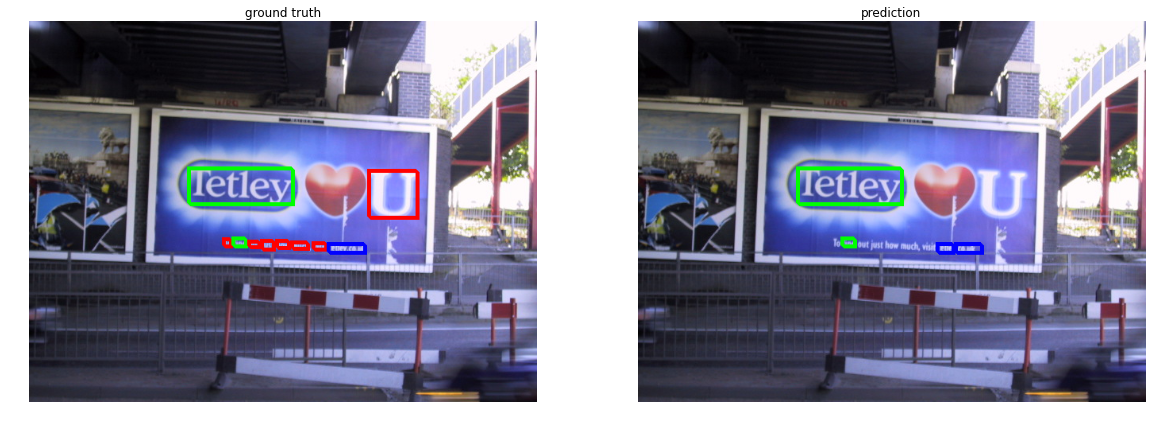

get operation:


In [28]:
root = parse_xml(imdir, bbdir)
recall_ratio = 0.8
precision_ratio = 0.5

wordbb = []
for entry in root:

    if entry['filename'] in whitelist:
        print entry['filename']
        img = plt.imread(os.path.join(imdir, entry['filename'])) # load image
        gt = bbstruct2coor(entry['bbstruct']) # get ground truth
        pred = res2coor(entry['filename'], bbtxtdir) # get prediction
        pre, rec = getEval(gt, pred) # get precision / recall
        mat = multiMatch(pre, rec, 0.5, 0.8) # get confusion index matrix
        #confmatShow(pre, rec, mat) # show confusion index matrix
        bbShow(img, mat, gt, pred) # show image with bounding box

        mode = raw_input('get operation:')
        if mode == '': # no operation
            wordbb.append([entry['filename'], pred])
        elif mode == 'p': # change to perfect detection
            wordbb.append([entry['filename'], gt])
        elif mode == 'd': # change to no detection (deletion)
            wordbb.append([entry['filename'], []])
        elif mode == 'm': # change to manually input detection
            ensure = 'no'
            while ensure != 'yes':
                print 'ground truth', gt
                print 'input label', pred
                pred = []
                while 1:
                    lineEntry = raw_input('input bb coordinates with whitespace delimiter')
                    if lineEntry:
                        lineEntry = lineEntry.split(' ')
                        lineEntry = [int(l) for l in lineEntry]
                        pred.append(lineEntry)
                    else:
                        break
                ensure = raw_input('please type yes to ensure the input is correct')
            wordbb.append([entry['filename'], pred])
        elif mode == 'a': # append
            ensure = 'no'
            while ensure != 'yes':
                print 'ground truth', gt
                print 'input label', pred
                while 1:
                    lineEntry = raw_input('input bb coordinates with whitespace delimiter')
                    if lineEntry:
                        lineEntry = lineEntry.split(' ')
                        lineEntry = [int(l) for l in lineEntry]
                        pred.append(lineEntry)
                    else:
                        break
                ensure = raw_input('please type yes to ensure the input is correct')
            wordbb.append([entry['filename'], pred])
        elif mode == 'subtract': # append
            print 'ground truth', gt
            print 'input label', pred
            while 1:
                lineEntry = raw_input('select index for which line to pop')
                if lineEntry:
                    temppred = pred.pop(int(lineEntry))
                    print 'ground truth', gt
                    print 'input label', pred
                else:
                    break
            wordbb.append([entry['filename'], pred])
        else:
            wordbb.append([entry['filename'], pred])
            
pickle.dump(wordbb, open('newpred.pkl', 'wb'))          

In [29]:
# import modules
import pickle
import os

wordbb = pickle.load(open('newpred.pkl', 'rb'))
for item in wordbb:
    filename = ''.join(['res_', item[0].split('.')[0], '.txt'])
    print filename
    
    with open(os.path.join('pred', filename), 'wb') as f:
        bblist = item[1]
        strlist = []
        for bb in bblist:
            bb = [str(x) for x in bb]
            bb = ','.join(bb)
            strlist.append(bb)
        strlist = '\r\n'.join(strlist)
        f.write(strlist)
        
import sys
sys.path.insert(0, '../python')
from zipFile import zipFile
zipFile('pred.zip', 'pred')

res_img_22.txt
pred.zip created.


In [31]:
2*81.63*93.39/(81.63+93.39)

87.11490915323964